# **Data 200 - Final Project**


Author:  Aryan Jain, Micah Billington, Rupesh Rangwani, Devesh Talreja

Date : 8th April, 2024

## **Summary Of Contents**

### This Final Project contains the following sections :
1. Introduction
2. Data Retrieval & Cleaning
3. Data Preprocessing & EDA
4. Model Application
5. Inference and Prediction
6. Conclusions

# 1. Introduction
<img src="Stack_Overflow.png" width="400" align="centre">

- How do programming language preferences vary across different age groups and experience levels among developers, based on the StackOverflow Developer Survey data?

- The full notebook and datasets can be found on GitHub: https://github.com/TrueCodee/Final-Project

# 2. Data Retrieval & Data Cleaning

### 2.1 Importing Libraries

In [1]:
#pip install statsmodels
#pip install imbalanced-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

### 2.2    Data Retrieval & Data Cleaning

In [3]:
# Import Data
df = pd.read_csv('survey_results_public.csv')

# Convert 'YearsCode' and 'YearsCodePro' to numeric, handling special cases
df['YearsCode'] = pd.to_numeric(df['YearsCode'], errors='coerce', downcast='integer')
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce', downcast='integer')

# Categorize 'YearsCodePro' into experience levels
def categorize_experience(years):
    if pd.isna(years):
        return 'Unknown'
    elif years <= 2:
        return 'Novice'
    elif years <= 5:
        return 'Intermediate'
    elif years <= 10:
        return 'Experienced'
    else:
        return 'Veteran'

df['ExperienceLevel'] = df['YearsCodePro'].apply(categorize_experience)

# Create binary indicators for programming languages of interest
languages_of_interest = ['Python', 'JavaScript', 'R', 'HTML/CSS', 'SQL', 'Java', 'C#', 'TypeScript', 'C', 'C++']
for language in languages_of_interest:
    # Escape special characters for regular expressions
    language_escaped = re.escape(language)
    df[language] = df['LanguageHaveWorkedWith'].str.contains(r'(?i)\b' + language_escaped + r'\b', na=False)


## 3. Data Processing

Age Group Analysis: Calculate Language Usage by Age Group

In [4]:
# Calculate the percentage of respondents in each age group who use Python and SQL
languages_of_interest_ds = ['Python','R','SQL']  # Adjusted list for data science relevant languages

age_language_usage = df.groupby('Age')[languages_of_interest_ds].mean().reset_index()

# Preparing the data for visualization (long format)
age_language_usage_long = pd.melt(age_language_usage, id_vars=['Age'], value_vars=languages_of_interest_ds, 
                                  var_name='Language', value_name='Usage')

Visualize Language Usage by Age Group

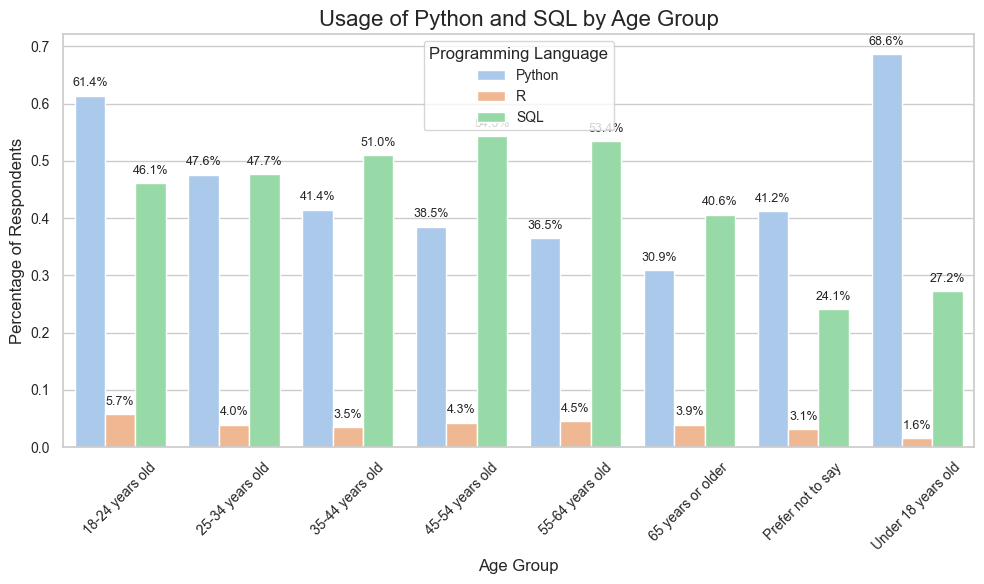

In [5]:
# Exploratory Data Analysis: Focus on Language Usage by Age
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Create the barplot
chart = sns.barplot(x='Age', y='Usage', hue='Language', data=age_language_usage_long)

# Customize the visual elements
chart.set_title('Usage of Python and SQL by Age Group', fontsize=16)
chart.set_ylabel('Percentage of Respondents', fontsize=12)
chart.set_xlabel('Age Group', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Programming Language', fontsize=10)

# Adding data labels on top of the bars
for p in chart.patches:
    # Get the height of the bar
    height = p.get_height()
    # If height is 0, we don't want to display the label
    if height > 0:
        chart.annotate(f'{height:.1%}', 
                       (p.get_x() + p.get_width() / 2., height), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points', fontsize=9)

plt.tight_layout()
plt.show()

## 4. Model Appication

### 4.1 Logistic Regression

This code uses SMOTE to oversample the minority class in your training data, addressing the class imbalance issue. This is critical for improving model performance on minority classes.

In [6]:
# Filter for users who have worked with Python, R, or SQL
df_langs = df[df['LanguageHaveWorkedWith'].str.contains('Python|R|SQL', regex=True, na=False)].copy()

# Create binary flags for Python, R, and SQL
df_langs['PyRSQL'] = df_langs['LanguageHaveWorkedWith'].str.contains('.*Python.*R.*SQL.*', regex=True).astype(int)

# Convert 'Age' to string to ensure that the dummy variables are handled correctly
df_langs['Age'] = df_langs['Age'].astype(str)

# Create dummy variables for the 'Age' groups
age_dummies = pd.get_dummies(df_langs['Age'], drop_first=True)
X_PyRSQL = sm.add_constant(age_dummies.astype(float))  # Add a constant to the model (the intercept)
y_PyRSQL = df_langs['PyRSQL']  # Response variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_PyRSQL, y_PyRSQL, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", dict(Counter(y_train_res)))

# Train a Logistic Regression Model using scikit-learn for prediction
log_reg_model_sklearn = LogisticRegression(solver='liblinear', random_state=42)
log_reg_model_sklearn.fit(X_train_res, y_train_res)

# Making predictions and evaluating the model
y_pred_sklearn = log_reg_model_sklearn.predict(X_test)
print("Classification Report (scikit-learn):\n", classification_report(y_test, y_pred_sklearn, zero_division=0))

Class distribution after SMOTE: {0: 48195, 1: 48195}
Classification Report (scikit-learn):
               precision    recall  f1-score   support

           0       0.91      0.80      0.85     12079
           1       0.14      0.29      0.18      1322

    accuracy                           0.75     13401
   macro avg       0.52      0.54      0.52     13401
weighted avg       0.83      0.75      0.78     13401



In [7]:
# Logistic Regression with statsmodels for Detailed Summary
X_train_res_const = sm.add_constant(X_train_res)  # Adding constant for statsmodels
model_PyRSQL_sm = sm.Logit(y_train_res, X_train_res_const).fit()
print("Model Summary (statsmodels):\n", model_PyRSQL_sm.summary())

Optimization terminated successfully.
         Current function value: 0.686478
         Iterations 5
Model Summary (statsmodels):
                            Logit Regression Results                           
Dep. Variable:                 PyRSQL   No. Observations:                96390
Model:                          Logit   Df Residuals:                    96382
Method:                           MLE   Df Model:                            7
Date:                Mon, 08 Apr 2024   Pseudo R-squ.:                0.009622
Time:                        15:36:29   Log-Likelihood:                -66170.
converged:                       True   LL-Null:                       -66812.
Covariance Type:            nonrobust   LLR p-value:                2.056e-273
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3492      0.013     26.507      0.000

## Model Comparison: Logistic Regression vs. Random Forest

This segment trains a Logistic Regression and a Random Forest Classifier on the balanced dataset and compares their performance. It helps in selecting the model that better handles the balanced data, indicated by improved classification metrics.

In [8]:
# Train Logistic Regression Model
log_reg_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
log_reg_model.fit(X_train_res, y_train_res)
y_pred_log_reg = log_reg_model.predict(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, y_train_res)
y_pred_rf = rf_model.predict(X_test)

# Compare models
# Evaluation: Logistic Regression
y_pred_lr = log_reg_model.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr, zero_division=0))
roc_auc_lr = roc_auc_score(y_test, log_reg_model.predict_proba(X_test)[:, 1])
print("Logistic Regression ROC AUC Score:", roc_auc_lr)

# Evaluation: Random Forest
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print("Random Forest ROC AUC Score:", roc_auc_rf)

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85     12079
           1       0.14      0.29      0.18      1322

    accuracy                           0.75     13401
   macro avg       0.52      0.54      0.52     13401
weighted avg       0.83      0.75      0.78     13401

Logistic Regression ROC AUC Score: 0.5633847844103475

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85     12079
           1       0.14      0.29      0.18      1322

    accuracy                           0.75     13401
   macro avg       0.52      0.54      0.52     13401
weighted avg       0.83      0.75      0.78     13401

Random Forest ROC AUC Score: 0.5633847844103475


## Hyperparameter Tuning for Random Forest

This code performs hyperparameter tuning for the Random Forest model using GridSearchCV. By identifying the best parameters, this step optimizes the model for better performance on the dataset. The comparison of classification reports before and after tuning demonstrates the effectiveness of hyperparameter optimization.

In [9]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    # Include more parameters here
}

# Initialize the grid search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',  # Choose an appropriate scoring method
    cv=5,               # Number of folds in cross-validation
    n_jobs=-1,          # Use all available cores
    verbose=2,
)

# Fit the grid search to the data
grid_search.fit(X_train_res, y_train_res)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best ROC AUC Score: 0.5583651551478334


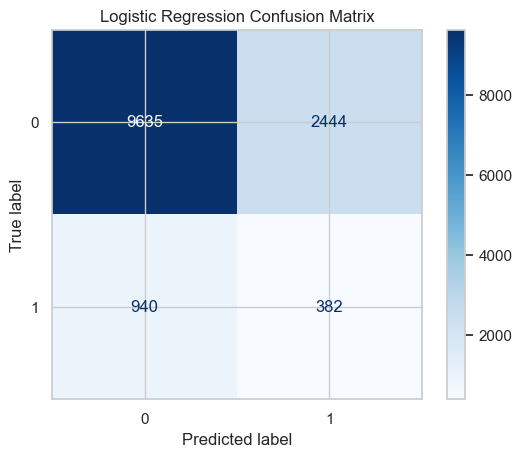

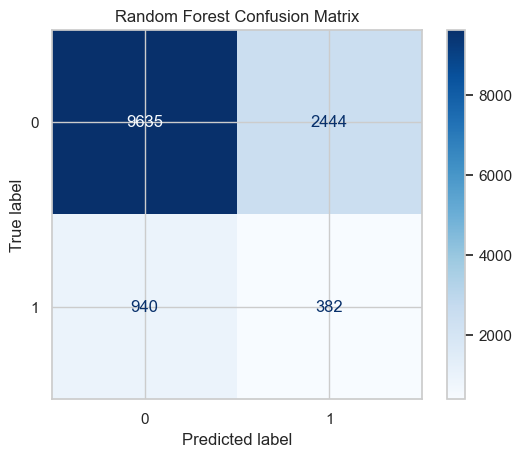

In [10]:
# Assuming log_reg_model and rf_model are your trained Logistic Regression and Random Forest models respectively
# And X_test, y_test are your test features and labels

# For Logistic Regression
cm_lr = confusion_matrix(y_test, log_reg_model.predict(X_test))
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# For Random Forest
cm_rf = confusion_matrix(y_test, rf_model.predict(X_test))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show()

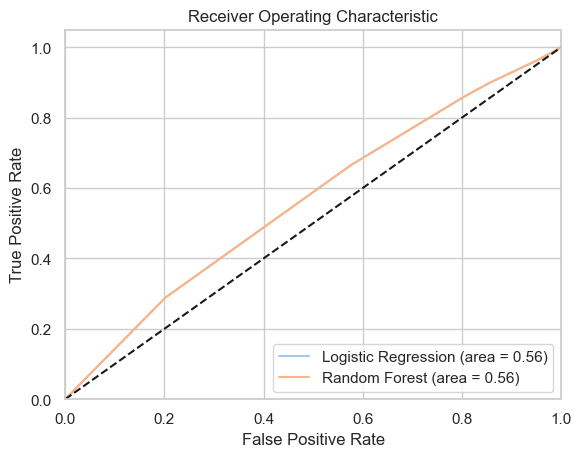

In [11]:

# Compute ROC curve for both models
fpr_lr, tpr_lr, _ = roc_curve(y_test, log_reg_model.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

# Plot ROC curves
plt.figure()
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (area = %0.2f)' % auc(fpr_lr, tpr_lr))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % auc(fpr_rf, tpr_rf))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Boosted Model Based on Classification

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

In [16]:
def misclassification_error(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

df_boost = df.loc[:,['YearsCode', 'YearsCodePro', 'CompTotal', 'Age', 'LanguageHaveWorkedWith']].dropna()
X_Boost = df_boost.loc[:,['YearsCode', 'YearsCodePro', 'CompTotal']]

df_boost['PyRSQL'] = df_boost['LanguageHaveWorkedWith'].str.contains('.*Python.*R.*SQL.*', regex=True).astype(int)
df_boost['Py'] = df_boost['LanguageHaveWorkedWith'].str.contains('.*Python.*', regex=True).astype(int)
df_boost['R'] = df_boost['LanguageHaveWorkedWith'].str.contains('.*R.*', regex=True).astype(int)
df_boost['SQL'] = df_boost['LanguageHaveWorkedWith'].str.contains('.*SQL.*', regex=True).astype(int)

y_Boost_list = ['Py', 'R','SQL']
models_Boost = []
models_dummy = []
models_decision = []

for i in y_Boost_list:
    X_train, X_test, y_train, y_test = train_test_split(X_Boost.to_numpy(), df_boost[i].to_numpy(), test_size=0.3, random_state=42)

    weak_learner = DecisionTreeClassifier(max_leaf_nodes=8)
    n_estimators = 200

    adaboost_clf = AdaBoostClassifier(
    estimator=weak_learner,
    n_estimators=n_estimators,
    algorithm="SAMME",
    random_state=42,
    ).fit(X_train, y_train)
    dummy_clf = DummyClassifier()

    weak_learners_misclassification_error = misclassification_error(
    y_test, weak_learner.fit(X_train, y_train).predict(X_test)
    )

    dummy_classifiers_misclassification_error = misclassification_error(
    y_test, dummy_clf.fit(X_train, y_train).predict(X_test)
    )

    print(
        "DecisionTreeClassifier's misclassification_error: "
        f"{weak_learners_misclassification_error:.5f}"
    )
    print(
        "DummyClassifier's misclassification_error: "
        f"{dummy_classifiers_misclassification_error:.5f}"
    )
    
    boosting_errors = pd.DataFrame(
        {
            "Number of trees": range(1, n_estimators + 1),
            "AdaBoost": [
                misclassification_error(y_test, y_pred)
                for y_pred in adaboost_clf.staged_predict(X_test)
            ],
        }
    ).set_index("Number of trees")
    
    # Record Models & Error
    models_Boost.append([adaboost_clf, boosting_errors])
    models_dummy.append([dummy_clf, dummy_classifiers_misclassification_error])
    models_decision.append([weak_learner, weak_learners_misclassification_error])

DecisionTreeClassifier's misclassification_error: 0.43395
DummyClassifier's misclassification_error: 0.44714
DecisionTreeClassifier's misclassification_error: 0.19948
DummyClassifier's misclassification_error: 0.19948
DecisionTreeClassifier's misclassification_error: 0.47122
DummyClassifier's misclassification_error: 0.48161


In [40]:
boosting_errors

,AdaBoost
Number of trees,
1,0.433947
2,0.433947
3,0.429073
4,0.421834
5,0.421834
...,...
196,0.417533
197,0.417533
198,0.417533


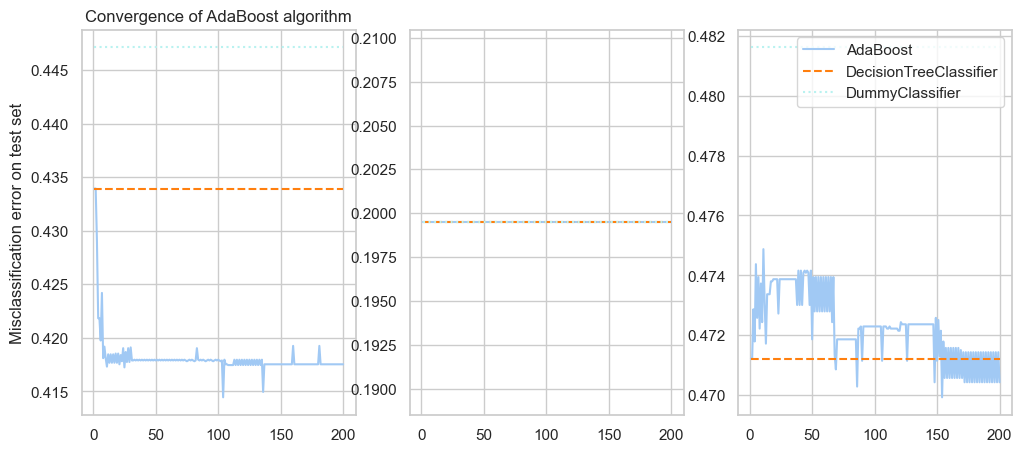

In [41]:
def plot_error(boosting_errors, weak_learners_misclassification_error, dummy_classifiers_misclassification_error, position):
    ax[position].plot(boosting_errors.index, boosting_errors)
    ax[position].plot(
        [boosting_errors.index.min(), boosting_errors.index.max()],
        [weak_learners_misclassification_error, weak_learners_misclassification_error],
        color="tab:orange",
        linestyle="dashed",
    )
    ax[position].plot(
        [boosting_errors.index.min(), boosting_errors.index.max()],
        [
            dummy_classifiers_misclassification_error,
            dummy_classifiers_misclassification_error,
        ],
        color="c",
        linestyle="dotted",
    )
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12,5))
ax[0].set_ylabel("Misclassification error on test set")
ax[0].set_title("Convergence of AdaBoost algorithm")
plot_error(models_Boost[0][1], models_decision[0][1], models_dummy[0][1], 0)
plot_error(models_Boost[1][1], models_decision[1][1], models_dummy[1][1], 1)
plot_error(models_Boost[2][1], models_decision[2][1], models_dummy[2][1], 2)
plt.legend(["AdaBoost", "DecisionTreeClassifier", "DummyClassifier"], loc=1)

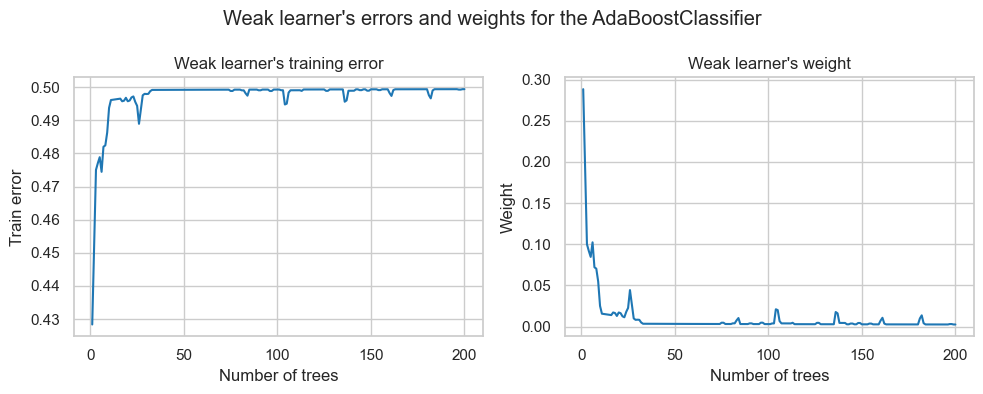

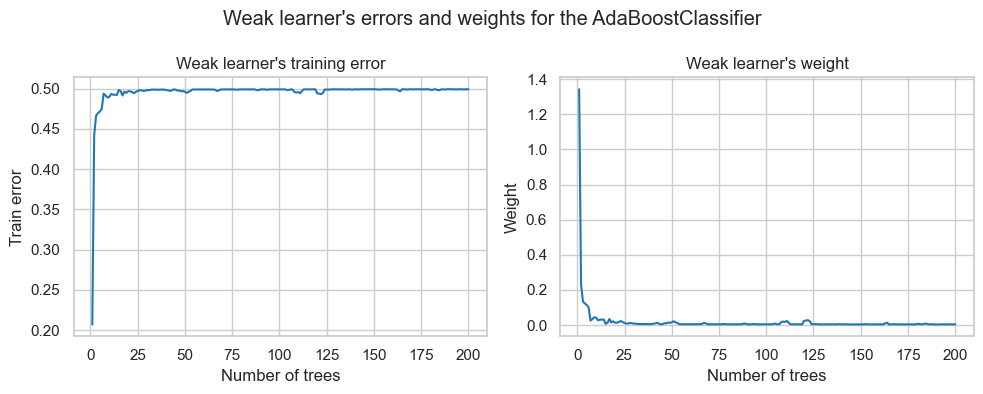

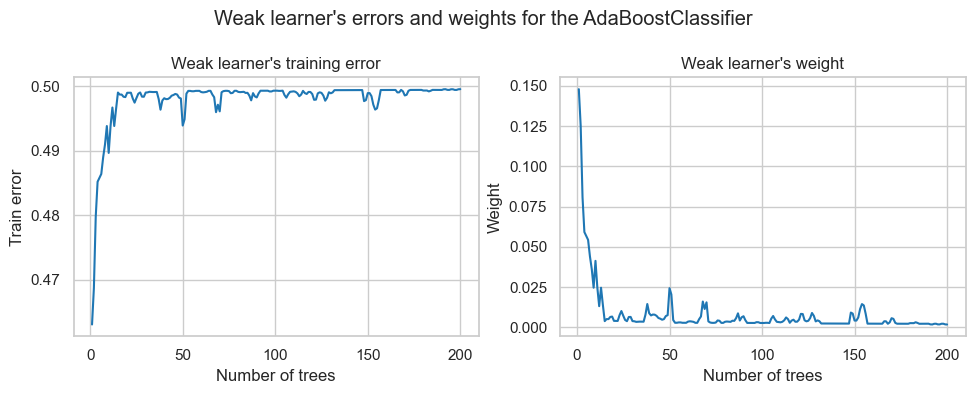

In [14]:
for clf in models_Boost:
    weak_learners_info = pd.DataFrame(
        {
            "Number of trees": range(1, n_estimators + 1),
            "Errors": clf.estimator_errors_,
            "Weights": clf.estimator_weights_,
        }
    ).set_index("Number of trees")

    axs = weak_learners_info.plot(
        subplots=True, layout=(1, 2), figsize=(10, 4), legend=False, color="tab:blue"
    )
    axs[0, 0].set_ylabel("Train error")
    axs[0, 0].set_title("Weak learner's training error")
    axs[0, 1].set_ylabel("Weight")
    axs[0, 1].set_title("Weak learner's weight")
    fig = axs[0, 0].get_figure()
    fig.suptitle("Weak learner's errors and weights for the AdaBoostClassifier")
    fig.tight_layout()

## 5. Inference & Prediction

In [ ]:
# Make predictions for combined usage
y_pred_log_reg_combined = log_reg_model_combined.predict(X_test_combined)
y_pred_proba_log_reg_combined = log_reg_model_combined.predict_proba(X_test_combined)[:, 1]

# Evaluation for combined usage
roc_auc_log_reg_combined = roc_auc_score(y_test_combined, y_pred_proba_log_reg_combined)
accuracy_log_reg_combined = accuracy_score(y_test_combined, y_pred_log_reg_combined)
report_log_reg_combined = classification_report(y_test_combined, y_pred_log_reg_combined, zero_division=0)

print("Logistic Regression - Combined Python, R, and SQL usage")
print("AUC-ROC:", roc_auc_log_reg_combined)
print("Accuracy:", accuracy_log_reg_combined)
print(report_log_reg_combined)

NameError: name 'log_reg_model_combined' is not defined